# Prompting with images
In this tutorial, you will upload images using the File API or as inline data and generate content based on those images.

***Technical details (images)***

Gemini 2.0 Flash, 1.5 Pro, and 1.5 Flash support a maximum of 3,600 image files.

Images must be in one of the following image data MIME types:

- PNG - image/png
- JPEG - image/jpeg
- WEBP - image/webp
- HEIC - image/heic
- HEIF - image/heif

### Tokens
Here's how tokens are calculated for images:

- Gemini 1.0 Pro Vision: Each image accounts for 258 tokens.
- Gemini 1.5 Flash and Gemini 1.5 Pro: If both dimensions of an image are less than or equal to 384 pixels, then 258 tokens are used. If one dimension of an image is greater than 384 pixels, then the image is cropped into tiles. Each tile size defaults to the smallest dimension (width or height) divided by 1.5. If necessary, each tile is adjusted so that it's not smaller than 256 pixels and not greater than 768 pixels. Each tile is then resized to 768x768 and uses 258 tokens.
- Gemini 2.0 Flash: Image inputs with both dimensions <=384 pixels are counted as 258 tokens. Images larger in one or both dimensions are cropped and scaled as needed into tiles of 768x768 pixels, each counted as 258 tokens.

#### **Get a bounding box for an object**
Gemini models are trained to return bounding box coordinates as relative widths or heights in the range of [0, 1]. These values are then scaled by 1000 and converted to integers. Effectively, the coordinates represent the bounding box on a 1000x1000 pixel version of the image. Therefore, you'll need to convert these coordinates back to the dimensions of your original image to accurately map the bounding boxes.

In [4]:
from google import genai
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
sample_file_1="https://static.toiimg.com/thumb/msid-118701222,imgsize-13452,width-400,resizemode-4/118701222.jpg"

client = genai.Client(api_key=api_key)

prompt = (
  "Return a bounding box for each of the objects in this image "
  "in [ymin, xmin, ymax, xmax] format.")

response = client.models.generate_content(
  model="gemini-1.5-pro",
  contents=[sample_file_1, prompt])

print(response.text)

The image shows a group of people gathered, seemingly for a photo.  Here's a breakdown of bounding boxes for the discernible individuals, keeping in mind the limitations of the image resolution and occlusion:

* **Person 1 (Back row, leftmost - partially obscured):** [0, 0, 310, 80]  (Significant portion hidden)
* **Person 2 (Back row, second from left):** [0, 70, 350, 170] (Partially obscured by person 1)
* **Person 3 (Back row, center):** [10, 150, 370, 250]
* **Person 4 (Back row, second from right):** [0, 230, 360, 340]
* **Person 5 (Back row, rightmost - partially obscured):** [20, 320, 360, 400] (Partially hidden)
* **Person 6 (Front row, leftmost):** [170, 0, 400, 100] (Partially obscured, lower body only visible)
* **Person 7 (Front row, second from left):** [170, 80, 400, 180] (Lower body mainly visible)
* **Person 8 (Front row, center):** [190, 170, 400, 290]
* **Person 9 (Front row, second from right):** [190, 260, 400, 380] (Lower body mainly visible)


**Important Consider

## **Image segmentation**
Starting with the 2.5 generation, Gemini models are trained to not only detect items but segment them and provide a mask of their contour.

In [5]:
from google import genai

client = genai.Client(api_key=api_key)
sample_file_1="https://static.toiimg.com/thumb/msid-118701222,imgsize-13452,width-400,resizemode-4/118701222.jpg"

prompt = """
  Give the segmentation masks for the wooden and glass items.
  Output a JSON list of segmentation masks where each entry contains the 2D
  bounding box in the key "box_2d", the segmentation mask in key "mask", and
  the text label in the key "label". Use descriptive labels.
"""

response = client.models.generate_content(
  model="gemini-2.5-pro-exp-03-25",
  contents=[sample_file_1, prompt])

print(response.text)

```json
[
  {"box_2d": [493, 580, 711, 810], "mask": "<start_of_mask><seg_115><seg_115><seg_48><seg_57><seg_115><seg_26><seg_27><seg_117><seg_13><seg_94><seg_27><seg_19><seg_11><seg_50><seg_17><seg_65>", "label": "glass jar"},
  {"box_2d": [701, 482, 842, 655], "mask": "<start_of_mask><seg_115><seg_115><seg_37><seg_61><seg_115><seg_70><seg_51><seg_117><seg_29><seg_94><seg_51><seg_66><seg_11><seg_17><seg_17><seg_65>", "label": "small glass bowl"},
  {"box_2d": [281, 187, 886, 977], "mask": "<start_of_mask><seg_115><seg_115><seg_59><seg_71><seg_115><seg_18><seg_51><seg_117><seg_63><seg_94><seg_51><seg_19><seg_11><seg_17><seg_17><seg_65>", "label": "wooden cutting board"},
  {"box_2d": [381, 352, 786, 682], "mask": "<start_of_mask><seg_115><seg_115><seg_59><seg_71><seg_115><seg_26><seg_51><seg_117><seg_13><seg_94><seg_51><seg_19><seg_11><seg_17><seg_17><seg_65>", "label": "wooden bowl"},
  {"box_2d": [372, 307, 760, 482], "mask": "<start_of_mask><seg_115><seg_115><seg_58><seg_71><seg_115>

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import requests
from io import BytesIO
import re

def parse_segmentation_masks(response_text, img_height, img_width):
    """
    Parse the segmentation masks from the API response text.
    
    Args:
        response_text (str): The text response from the API containing JSON data
        img_height (int): Height of the original image
        img_width (int): Width of the original image
        
    Returns:
        list: A list of dictionaries containing parsed segmentation mask data
    """
    # Try to extract JSON from the response text
    # Sometimes the API wraps JSON in markdown code blocks or has additional text
    json_match = re.search(r'```json\n(.*?)\n```', response_text, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
    else:
        # Try to find anything that looks like a JSON array
        json_match = re.search(r'\[\s*{.*}\s*\]', response_text, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
        else:
            json_str = response_text
    
    try:
        # Parse the JSON data
        data = json.loads(json_str)
        
        # Process each mask
        for item in data:
            if "mask" in item:
                # Handle different mask formats (could be array or run-length encoding)
                if isinstance(item["mask"], list):
                    # If mask is already a 2D array, convert to numpy array
                    mask = np.array(item["mask"], dtype=np.uint8)
                elif isinstance(item["mask"], str):
                    # If mask is a run-length encoded string, decode it
                    mask = decode_rle(item["mask"], img_height, img_width)
                else:
                    mask = np.zeros((img_height, img_width), dtype=np.uint8)
                
                item["mask"] = mask
        
        return data
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        print("Response text:", response_text)
        return []

def decode_rle(rle_string, height, width):
    """
    Decode run-length encoded mask string to a binary mask.
    
    Args:
        rle_string (str): Run-length encoded mask string
        height (int): Height of the image
        width (int): Width of the image
        
    Returns:
        numpy.ndarray: Binary mask
    """
    # This is a simplified RLE decoder - you may need to adjust based on the exact format returned
    mask = np.zeros((height * width), dtype=np.uint8)
    
    # Parse the RLE string
    # Format might vary, this assumes comma-separated values of (start_idx, length)
    pairs = rle_string.split(',')
    for i in range(0, len(pairs), 2):
        if i + 1 < len(pairs):
            start_idx = int(pairs[i].strip())
            length = int(pairs[i + 1].strip())
            mask[start_idx:start_idx + length] = 1
    
    return mask.reshape(height, width)

def plot_segmentation_masks(image, segmentation_masks):
    """
    Plot the segmentation masks on the image.
    
    Args:
        image: PIL Image or path to image
        segmentation_masks (list): List of dictionaries containing mask data
    """
    # Load the image if it's a URL or path
    if isinstance(image, str):
        if image.startswith('http'):
            response = requests.get(image)
            image = Image.open(BytesIO(response.content))
        else:
            image = Image.open(image)
    
    # Convert PIL Image to numpy array if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12, 10))
    
    # Display the original image
    ax.imshow(img_array)
    
    # Define colors for different masks
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'magenta', 'orange']
    
    # Plot each mask
    for i, mask_data in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        
        # Plot the mask with transparency
        if "mask" in mask_data and mask_data["mask"] is not None:
            mask = mask_data["mask"]
            # Create a colored mask with transparency
            colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
            colored_mask[mask > 0] = plt.cm.colors.to_rgba(color, alpha=0.3)
            
            ax.imshow(colored_mask, interpolation='none')
        
        # Draw bounding box if available
        if "box_2d" in mask_data:
            box = mask_data["box_2d"]
            # Expecting box format: [x_min, y_min, width, height] or [x_min, y_min, x_max, y_max]
            if len(box) == 4:
                if box[2] > box[0] and box[3] > box[1]:  # x_max, y_max format
                    x, y = box[0], box[1]
                    width, height = box[2] - box[0], box[3] - box[1]
                else:  # width, height format
                    x, y = box[0], box[1]
                    width, height = box[2], box[3]
                
                rect = Rectangle((x, y), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
        
        # Add label if available
        if "label" in mask_data:
            # Position label at the top of the bounding box or center of mask
            if "box_2d" in mask_data:
                box = mask_data["box_2d"]
                if len(box) == 4:
                    label_x = box[0]
                    label_y = box[1] - 5
            else:
                # Find the center of the mask
                if "mask" in mask_data and mask_data["mask"] is not None:
                    mask = mask_data["mask"]
                    y_indices, x_indices = np.where(mask > 0)
                    if len(y_indices) > 0 and len(x_indices) > 0:
                        label_x = np.mean(x_indices)
                        label_y = np.min(y_indices) - 5
                    else:
                        label_x = 0
                        label_y = 0
                else:
                    label_x = 0
                    label_y = 0
            
            ax.text(label_x, label_y, mask_data["label"], 
                   color='white', fontsize=12, backgroundcolor=color)
    
    ax.set_title('Segmentation Masks')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return fig

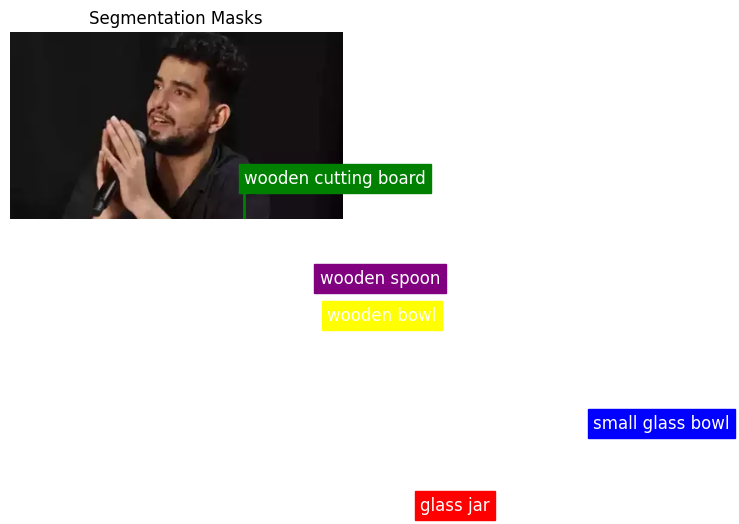

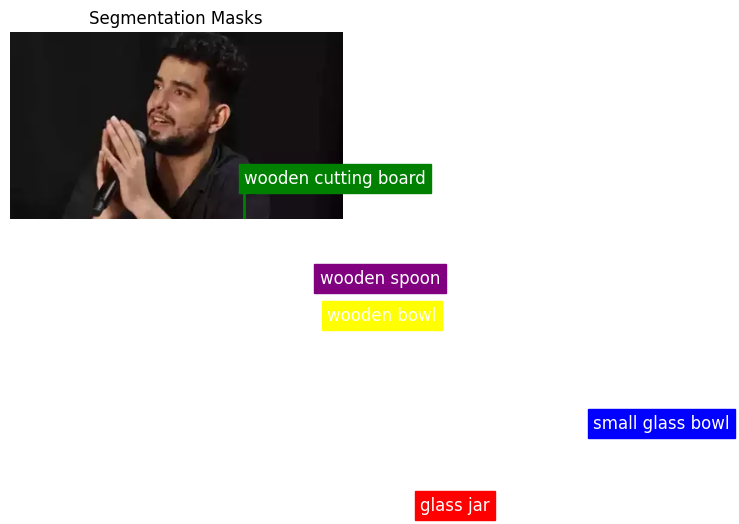

In [10]:
response_img = requests.get(sample_file_1)
im = Image.open(BytesIO(response_img.content))
segmentation_masks = parse_segmentation_masks(response.text, img_height=im.size[1], img_width=im.size[0])
plot_segmentation_masks(im, segmentation_masks)